## Summary
In this notebook, we create tfrecord of vial images. We want tfrecords so eventually we can create a TFX pipeline.

* https://www.kaggle.com/code/ryanholbrook/tfrecords-basics/notebook

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def flatten_images(image, label):
    """
    we need to flatten the image because tfrecords can only store 1d arrays.
    we use tf.reshape instead of numpy reshape because tfdata automatically converts numpy to tensors, which means we need to work in tf land not python land.
    """
    image = tf.reshape(image,[-1])
    return image, label


# https://www.tensorflow.org/tutorials/load_data/tfrecord
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _floats_feature(value):
    # no bracket since we're passing an array, not a scalar
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))  

def serialize_example(image, label):

    features = Features(feature={
        'image': _floats_feature(image),
        'label': _int64_feature(label),
    })
    
    example = Example(features=features)
    return example.SerializeToString()

## Read data into tfdata

In [2]:
# load images into tfdata, which is now a dataframe of np floats
# we will need to convert this from a tfdata of floats to bytes, which will then allow us to save as tfrecords
train_ds = tf.keras.utils.image_dataset_from_directory('./train')

Found 209 files belonging to 2 classes.


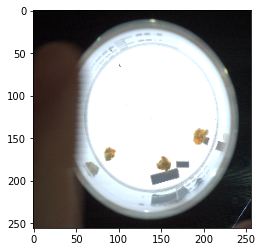

In [16]:
# inspect dataset so we know what we're working with
X, y = next(iter(train_ds))
plt.imshow(X[0].numpy().astype(int))

In [19]:
ds_train_flattened = train_ds.unbatch().map(flatten_images)
ds_train_flattened

## Write data to tfrecords

In [23]:
# https://www.kaggle.com/code/ryanholbrook/walkthrough-building-a-dataset-of-tfrecords/notebook
PATH = './shard_{:02d}.tfrecord'
NUM_SHARDS = 2

for shard in range(NUM_SHARDS):
    ds_shard = (ds_train_flattened.shard(NUM_SHARDS, shard).as_numpy_iterator())
    
    with tf.io.TFRecordWriter(path=PATH.format(shard)) as f:
        for image, label in ds_shard:
            example = serialize_example(image, label)
            f.write(example)

## Reading from tfrecords

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [45]:
# as usual, we need the original spec to reread bytes to tf land
spec = {
    'label':tf.io.FixedLenFeature([], tf.int64),
    'image' : tf.io.FixedLenFeature([196608], tf.float32)  # 256x256x3 image was flattened so it could be serialized into bytes
}

def parse_example(element):
    e = tf.io.parse_single_example(element, spec)
    label = e['label']
    image = e['image']
    return {'image': image, 'label': label}

In [70]:
dset = tf.data.TFRecordDataset(["./shard_01.tfrecord"])
dset = dset.map(parse_example)

In [71]:
example = next(iter(dset))

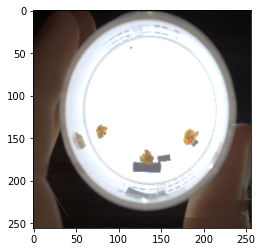

In [69]:
# each example is read as a flat 1d tensor, which is converted to a 3d numpy array
img = example['image'].numpy().reshape((256, 256, 3)).astype(int)
plt.imshow(img)